# Import libraries

In [1]:
!pip install swig
!pip install gym[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.0 MB/s eta 0:00:0000:0100:01
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495182 sha256=fae1192381146391918c20e139eadf97759bb34c4d41aa44d291682801382481
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import gym
from pyvirtualdisplay import Display

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import PIL
import copy

import torch
from torch import nn
import torch.nn.functional as F

# Building the environment

In [3]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Dueling architecture

In [4]:
class D3DQN(nn.Module):
    def __init__(self, input_observations, action_num, lr, chkpt_dir, name):
        super(D3DQN, self).__init__()
        # Save checkpoint path
        self.chkpt_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.chkpt_dir, name)
        # Create the layers               
        self.input = nn.Linear(input_observations, 256)
        
        # V stream
        self.V = nn.Linear(256, 256)
        self.V_output = nn.Linear(256,1)
        
        # A stream
        self.A = nn.Linear(256, 256)
        self.A_output = nn.Linear(256,action_num)
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = torch.nn.HuberLoss()
        
        # Set the GPU or CPU configuration for the network
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, obs_state):
        
        # Input stream
        input = F.relu(self.input(obs_state))       
        
        # V stream
        V = F.relu(self.V(input))
        V = self.V_output(V)
        
        # A stream
        A = F.relu(self.A(input))
        A = self.A_output(A)
        
        return V, A
    
    def save_checkpoint(self):
        print("... saving checkpoint ...")
        torch.save(self.state_dict(), self.checkpoint_file)
        
         

# Replay memory

In [5]:
class ReplayBuffer:

    def __init__(self, max_size, pointer):
        # Memory
        self.storage = []
        # Memory size
        self.max_size = max_size
        # Memory pointer
        self.experience_ind = pointer        
        # Full memory flag
        self.full_storage_flag = False

    def add(self, experience):
        # Add experience                 
        if self.experience_ind >= self.max_size:
            self.full_storage_flag = True
            self.experience_ind = 0                
        if self.full_storage_flag:
            self.storage[self.experience_ind] = experience
        else:
            self.storage.append(experience)        
        # Increase pointer
        self.experience_ind += 1        

    def sample(self, batch_size):
        # Select the experience in memory
        batch = np.random.choice(len(self.storage), batch_size, replace=False)        
        minibatch_rewards = []
        minibatch_dones = []        
        minibatch_actions = []
        minibatch_current_state = []
        minibatch_next_state = []

        for i in batch:            
            # Get current state            
            minibatch_current_state.append(self.storage[i][0]) 
                       
            # Get next state
            minibatch_next_state.append(self.storage[i][3])                                         
            
            # Get reward           
            minibatch_rewards.append(self.storage[i][1])                        
            # Get dones
            minibatch_dones.append(self.storage[i][4])
            # Get actions
            minibatch_actions.append(self.storage[i][2])
            
        return minibatch_current_state, np.array(minibatch_rewards), np.array(minibatch_actions), minibatch_next_state, np.array(minibatch_dones)

# D3DQN algorithm

In [7]:
class DRLAlgorithm:
    def __init__(self):
        
        # Epsilon greedy policy
        self.epsilon = 1.0
        self.epsilon_final = 0.01
        self.epsilon_interval = 1.0 - self.epsilon_final
        self.epsilon_greedy_frames = 500_000
        
        # Networks
        self.q_net = D3DQN(
            input_observations=8,
            action_num=env.action_space.n,
            lr=0.00015,
            chkpt_dir="/kaggle/working/",
            name = "lunar_lander_model"
        )
        self.q_target_net = D3DQN(
            input_observations=8,
            action_num=env.action_space.n,
            lr=0.00015,
            chkpt_dir="/kaggle/working/",
            name = "lunar_lander_target_model"
        )
        # Copy weights
        self.q_target_net.load_state_dict(self.q_net.state_dict())
        # Batch size
        self.batch_size = 32       
        # Update target network weight counter
        self.update_network_counter = 0
        
        # Memory
        self.memory = ReplayBuffer(1_000_000, 0)
        self.replay_exp_initial_condition = 5000
        
        # Algorithm
        self.discount_factor = 0.99           
    
    def policy(self, state):        
        if np.random.rand() <= self.epsilon:
            # Select a random action
            action = np.random.randint(0,env.action_space.n)
            return action
                
        # Expand dimensions 
        state_tensor = torch.tensor(state).to(self.q_net.device)
        # Forward step
        V, A = self.q_net.forward(state_tensor)       
        # Compute Qs and selecting the action
        A_mean = torch.mean(A)       
        action = torch.argmax((V + (A - A_mean))).item()   
        return action
    
    def train(self):
        
        if self.memory.experience_ind <= self.replay_exp_initial_condition:
            return
        # Sampling
        states_batch, rewards_batch, actions_batch, next_states_batch, dones_batch = self.memory.sample(self.batch_size)
        # Convert the numpy batches to tensors
        states = torch.tensor(states_batch).to(self.q_net.device)
        next_states = torch.tensor(next_states_batch).to(self.q_net.device)
        rewards = torch.tensor(rewards_batch).to(self.q_net.device)
        actions = torch.tensor(actions_batch).to(self.q_net.device)
        dones = torch.tensor(dones_batch).to(self.q_net.device)
        
        self.q_net.optimizer.zero_grad()
        
        indices = np.arange(self.batch_size)
        # Perform the Double DQN algorithm
        V_s, A_s = self.q_net.forward(states)
        V_s_target, A_s_target = self.q_target_net.forward(next_states)                
        V_s_eval, A_s_eval = self.q_net.forward(next_states)
        
        q_pred = torch.add(V_s,
                          (A_s - A_s.mean(dim=1, keepdim=True)))[indices, actions_batch]
        
        q_next = torch.add(V_s_target, (A_s_target - A_s_target.mean(dim=1, keepdim=True)))
        q_eval = torch.add(V_s_eval, (A_s_eval - A_s_eval.mean(dim=1, keepdim=True)))
        
        max_actions = torch.argmax(q_eval, dim=1)
        
        q_next[dones] = 0.0
        q_target = rewards + self.discount_factor * q_next[indices, max_actions]       
        
        # Calculate the loss function
        loss = self.q_net.loss(q_target.double(), q_pred.double()).to(self.q_net.device)
        # Backpropagation
        loss.backward()
        # Optimizer step
        self.q_net.optimizer.step()
        # Epsilon decreased
        self.epsilon -= self.epsilon_interval / self.epsilon_greedy_frames
        self.epsilon = max(self.epsilon, self.epsilon_final)
        
        self.update_network_counter += 1
        # Update the target network weight each 150 training steps
        if self.update_network_counter == 150:
            # Copy weights
            self.q_target_net.load_state_dict(self.q_net.state_dict())
            self.update_network_counter = 1
        
    def save_model(self):
        # Save the models
        self.q_net.save_checkpoint()
        self.q_target_net.save_checkpoint()
    
    def load_model(self):
        # Load the models
        print("... loading model ...")
        self.q_net.load_state_dict(torch.load("model/lunar_lander_model"))          
        self.q_target_net.load_state_dict(torch.load("model/lunar_lander_target_model"))          
        self.q_target_net.load_state_dict(self.q_net.state_dict())        
        
drl = DRLAlgorithm()

# Training

In [8]:
num_episodes = 5000
scores = []
eps_history = []
for episode in range(num_episodes):
    done = False
    truncated = False
    state = env.reset()    
    # Get current state
    state = state[0]
    score = 0
    
    while not done and not truncated:        
        # Select the action
        action = drl.policy(state)    
        # Perform the action selected
        next_state, reward, done, truncated, _ = env.step(action)    
        # Add experience to the memory
        experience = (tuple(state), reward, action, tuple(next_state), done)    
        score += reward        
        drl.memory.add(experience)    
        # Update current state for the next step
        state = np.copy(next_state)        
        # Training the network
        drl.train()        
    
    scores.append(score)
    avg_score = np.mean(scores[max(0, episode-100):(episode+1)])
    
    print('episode: ', episode,'score %.1f ' % score,
             ' average score %.1f' % avg_score,
            'epsilon %.2f' % drl.epsilon)
    eps_history.append(drl.epsilon)
    # Save the model training and the results each 100 episodes 
    if episode > 0 and episode % 100 == 0:
        drl.save_model()   
        
        memory = pd.Series(drl.memory.storage)
        memory.to_csv("/kaggle/working/memory.csv", header=False)   
        
        eps_history_temp = pd.Series(eps_history)
        eps_history_temp.to_csv("/kaggle/working/eps_history.csv", header=False)   
        scores_temp = pd.Series(scores)
        scores_temp.to_csv("/kaggle/working/scores.csv", header=False)   

/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode:  0 score -167.3   average score -167.3 epsilon 1.00
episode:  1 score -110.0   average score -138.7 epsilon 1.00
episode:  2 score -108.2   average score -128.5 epsilon 1.00
episode:  3 score -181.7   average score -141.8 epsilon 1.00
episode:  4 score -143.1   average score -142.1 epsilon 1.00
episode:  5 score -109.9   average score -136.7 epsilon 1.00
episode:  6 score -79.6   average score -128.6 epsilon 1.00
episode:  7 score -392.0   average score -161.5 epsilon 1.00
episode:  8 score -113.4   average score -156.1 epsilon 1.00
episode:  9 score -246.0   average score -165.1 epsilon 1.00
episode:  10 score -91.5   average score -158.4 epsilon 1.00
episode:  11 score -159.9   average score -158.6 epsilon 1.00
episode:  12 score -250.5   average score -165.6 epsilon 1.00
episode:  13 score -249.4   average score -171.6 epsilon 1.00
episode:  14 score -256.1   average score -177.2 epsilon 1.00
episode:  15 score -106.2   average score -172.8 epsilon 1.00
episode:  16 score -

# Plot training results

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

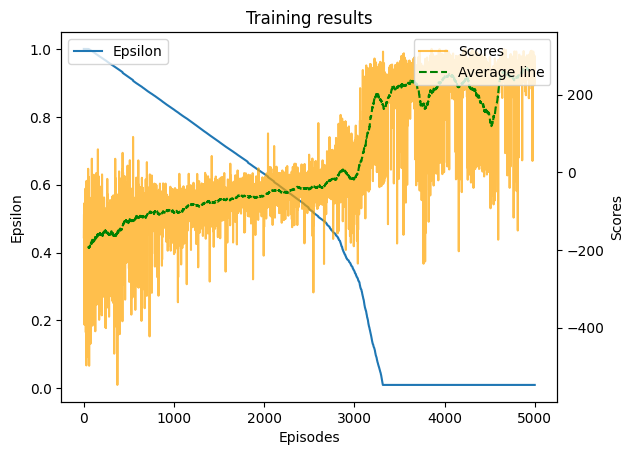

In [42]:
x = [i+1 for i in range(num_episodes)]
fig, ax1 = plt.subplots()
sns.lineplot(x=x, y=eps_history, ax=ax1, label='Epsilon')
ax2 = ax1.twinx()
sns.lineplot(x=x, y=scores, ax=ax2, label='Scores', alpha=0.7, color="#FFA500")
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Epsilon')
ax2.set_ylabel('Scores')

# Average
window_size = 100
rolling_average = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
x_rolling = x[window_size//2 : -(window_size//2) + 1]
ax2.plot(x_rolling, rolling_average, label='Average line', linestyle='--', color='green')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title("Training results")
plt.show()
fig.savefig("LunarLander-D3DQN-Adam-HuberLoss-lr00015.png")

# Testing the model trained

In [13]:
images = []
scores_test = []
for i in range(10):
    done = False
    truncated = False
    state = env.reset()    
    state = state[0]
    score = 0
    
    while not done and not truncated:  
        image = PIL.Image.fromarray(env.render()) # taking current state image
        images.append(image)
        action = drl.policy(state)    
        next_state, reward, done, truncated, _ = env.step(action)    
        
        score += reward
        
        state = np.copy(next_state)        
        
    
    scores_test.append(score)

images[0].save('show_landing.gif',save_all=True,append_images=images[1:],duration=100,loop=0) # saving images to a gif
    

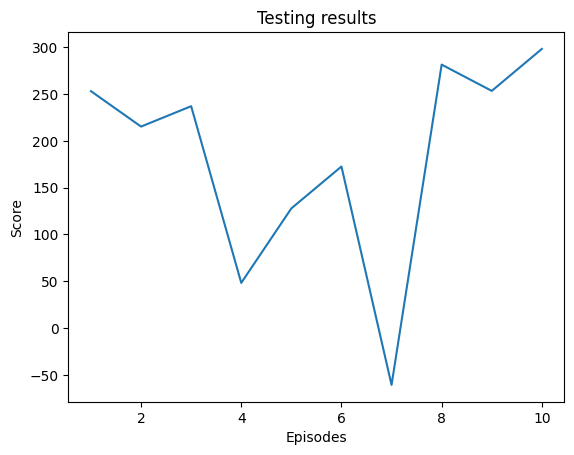

In [39]:
x = [i+1 for i in range(10)]
plt.plot(x, scores_test)
plt.title("Testing results")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.show()